# Emoji Reconstruction using Convolutional AutoEncoder

## Installing Required Libraries

In [ ]:
# HuggingFace datasets Library.
# Other libraries needed (already available in Colab) : TensorFlow, Numpy, Pillow, Pandas, Matplotlib
!pip3 install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.0 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.


## Importing the Required Packages

In [ ]:
# Tensorflow
import tensorflow as tf

# Tensorflow/Keras Layer Classes
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D

# Tensorflow/Keras Model Class
from tensorflow.keras.models import Model

# Tensorflow /Keras img_to_array
from tensorflow.keras.preprocessing.image import img_to_array

# Tensorflow's model visualization
from tensorflow.keras.utils import plot_model

# Numpy
import numpy as np

# dataset's load_dataset
from datasets import load_dataset

# HTML classes to visualize images in the dataframe
from IPython.display import HTML

import base64

# Pandas
import pandas as pd

# Pillow's Image Class
from PIL import Image

# BytesIO Class
from io import BytesIO

# Plotting using matplotlib
import matplotlib.pyplot as plt

# Sklearn's PCA class
from sklearn.decomposition import PCA

## Loading the Dataset using Huggingface Datasets Library

In [ ]:
dataset = load_dataset("valhalla/emoji-dataset")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/2749 [00:00<?, ? examples/s]

## Size of Dataset

In [ ]:
dataset['train'].shape[0]

2749

## Visualizing first 5 Emoji images in the dataset

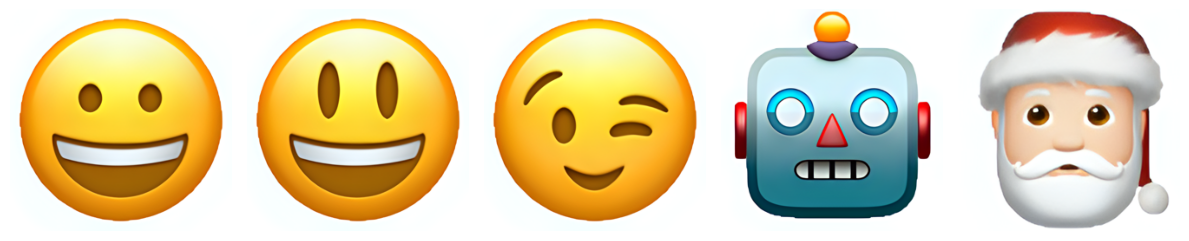

In [ ]:
def view_images(images):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(12, 8))

    for i, img in enumerate(images):
        # img = Image.open(images[i])
        axes[i].imshow(img)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Load the first 5 images in a list
images = [emoji for emoji in dataset['train'][0:5]['image']]
view_images(images)

## Only Train Split available in the original dataset. Splitting that into Train and Test.
## Also converting the images into grayscale to avoid Out of Memory Issue.

In [ ]:
# converts the images to grayscale and return them as numpy array
def pil_to_np_array(images):

  # Preprocess the images
  grayscale_images = []

  for image in images:
      img = image.convert('L')  # Convert image to grayscale
      img = img_to_array(img) / 255 # Normalize pixel values between 0 and 1
      grayscale_images.append(img)

  img_array = np.array(grayscale_images)

  return img_array


# Splits list into a ratio
def list_splitter(list_to_split, ratio):
    elements = len(list_to_split)
    middle = int(elements * ratio)
    return [list_to_split[:middle], list_to_split[middle:]]

# picking the first 70% images to work on.
images = dataset['train']['image']
images_np = pil_to_np_array(images)

X_train, X_test = list_splitter(images_np, 0.7)

## Let's checkout the dimensions of the split datasets

In [ ]:
# 1 since grayscale images have 1 channel
# remember for tensors typically dims are shown as (batch_size, height, width, channels)
X_train.shape, X_test.shape

((1924, 256, 256, 1), (825, 256, 256, 1))

## Defining and training the AutoEncoder Neural Network

### Defining the Encoder

In [ ]:
# Define the architecture of the convolutional autoencoder
input_shape = (256, 256, 1)  # Grayscale images have 1 channel

# Encoder

# Input Layer
encoder_input = Input(shape=input_shape, name='encoder_input')

# 1st hidden layer - convolutional with 16 filters of size 3x3
encoder_hidden = Conv2D(16, (3, 3), activation='relu', padding='same')(encoder_input)

# 2nd hidden layer - Max Pooling with a 2x2 window
# NOTE - remember pooling healps avoid overfitting and make the network more efficient
# It helps in retaining the most important features in the downsampled feature maps
encoder_hidden = MaxPooling2D((2, 2), padding='same')(encoder_hidden)

# 3rd hidden layer - convolutional with 8 filters of size 3x3
encoder_hidden = Conv2D(8, (3, 3), activation='relu', padding='same')(encoder_hidden)

# 4th hidden layer  - Max Pooling with a 2x2 window
encoder_hidden = MaxPooling2D((2, 2), padding='same')(encoder_hidden)

# 5th hidden layer - convolutional with 1 filter of size 3x3
encoder_hidden = Conv2D(1, (3, 3), activation='relu', padding='same')(encoder_hidden)

# Encoder Output Layer
encoder_output = MaxPooling2D((2, 2), padding='same', name='encoder_output')(encoder_hidden)

### Defining the Decoder - Notice that the layer scheme is reverse of encoder

In [ ]:
# Decoder

# Input Layer to decoder - convolutional with 1 filter of size 3x3
decoder_hidden = Conv2D(1, (3, 3), activation='relu', padding='same', name='decoder_input')(encoder_output)

# 1st hidden layer - Upsampling rows and columns with Factor 2
decoder_hidden = UpSampling2D((2, 2))(decoder_hidden)

# 2nd hidden layer - convolutional with 8 filters of size 3x3
decoder_hidden = Conv2D(8, (3, 3), activation='relu', padding='same')(decoder_hidden)

# 3rd hidden layer - Upsampling rows and columns with Factor 2
decoder_hidden = UpSampling2D((2, 2))(decoder_hidden)

# 4th hidden layer - convolutional with 16 filters of size 3x3
decoder_hidden = Conv2D(16, (3, 3), activation='relu', padding='same')(decoder_hidden)

# 5th hidden layer - Upsampling rows and columns with Factor 2
decoder_hidden = UpSampling2D((2, 2))(decoder_hidden)

# Decoder Output Layer - convolutional with 1 filters of size 3x3
decoder_output = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='decoder_output')(decoder_hidden)

### UpSampling2D - An example

```
1 2
3 4
```

UpSampling2D((2, 2)) means to upsample with a factor of 2

```
1 1 2 2
1 1 2 2
3 3 4 4
3 3 4 4
```




### Combine and Compile

In [ ]:
# Create the autoencoder model
autoencoder = Model(inputs=encoder_input, outputs=decoder_output)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

### Now visualize the layers of the Autoencoder. Notice the gradual decrease in the outputs of the hidden layers of the encoder, while the gradual increase in that of decoder. Also, note that the achitecture of decoder is reverse of that of encoder. For e.g. **input size of max_pooling2d_1 = output size of upsampling2d_1 = (None, 128, 128, 8)**

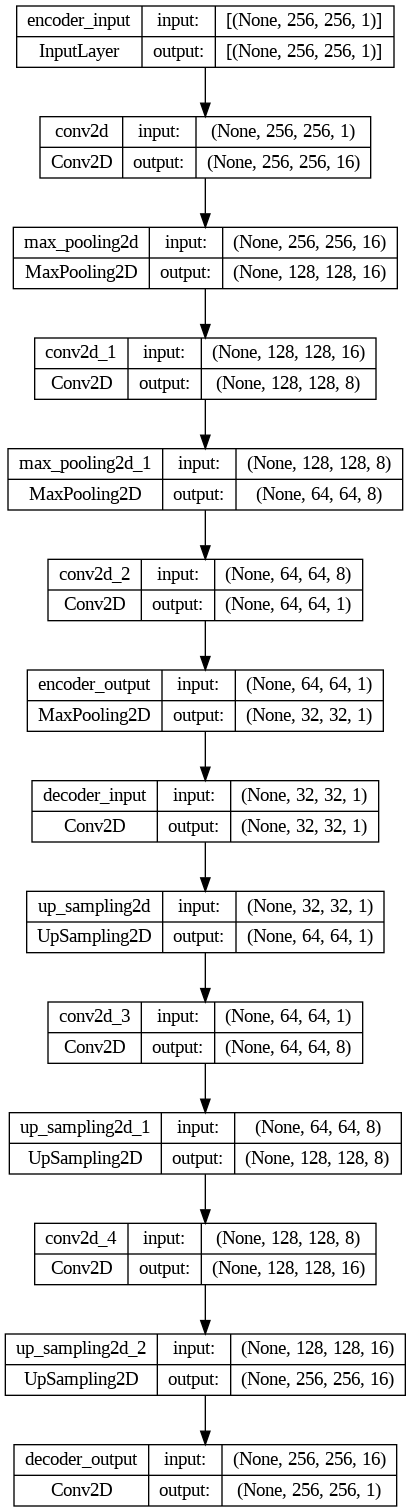

In [ ]:
# Visualize the architecture of the autoencoder
plot_model(autoencoder, to_file='autoencoder_architecture.png', show_shapes=True)

### Now train the model for 50 epochs

In [ ]:
# Train the autoencoder
history = autoencoder.fit(X_train, X_train, epochs=50, batch_size=128, validation_data=(X_test, X_test))

Epoch 1/50
16/16 [==============================] - 192s 12s/step - loss: 0.1498 - val_loss: 0.1342
Epoch 2/50
16/16 [==============================] - 188s 12s/step - loss: 0.1363 - val_loss: 0.1182
Epoch 3/50
16/16 [==============================] - 215s 14s/step - loss: 0.1096 - val_loss: 0.0786
Epoch 4/50
16/16 [==============================] - 211s 13s/step - loss: 0.0668 - val_loss: 0.0412
Epoch 5/50
16/16 [==============================] - 187s 12s/step - loss: 0.0354 - val_loss: 0.0226
Epoch 6/50
16/16 [==============================] - 198s 12s/step - loss: 0.0202 - val_loss: 0.0158
Epoch 7/50
16/16 [==============================] - 189s 12s/step - loss: 0.0157 - val_loss: 0.0136
Epoch 8/50
16/16 [==============================] - 188s 12s/step - loss: 0.0142 - val_loss: 0.0127
Epoch 9/50
16/16 [==============================] - 197s 12s/step - loss: 0.0132 - val_loss: 0.0123
Epoch 10/50
16/16 [==============================] - 188s 12s/step - loss: 0.0128 - val_loss: 0.0117

### Visualizing the Training and Validation Loss

In [ ]:
import matplotlib.pyplot as plt

# Obtain the training and validation loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss curves
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Inference - Visualize 5 random original vs reconstructed images from test dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Select a few random images from the test data for reconstruction
num_images = 5
sample_indices = np.random.choice(len(X_test), num_images, replace=False)
sample_images = X_test[sample_indices]

# Reshape the sample images to match the input shape of the autoencoder
sample_images_reshaped = sample_images.reshape(num_images, 256, 256, 1)

# Reconstruct the sample images using the autoencoder model
reconstructed_images = autoencoder.predict(sample_images_reshaped)

# Plot the original and reconstructed images
plt.figure(figsize=(10, 4))
for i in range(num_images):
    # Original image
    plt.subplot(2, num_images, i + 1)
    plt.imshow(sample_images[i], cmap='gray')
    plt.axis('off')
    plt.title('Original')

    # Reconstructed image
    plt.subplot(2, num_images, num_images + i + 1)
    plt.imshow(reconstructed_images[i], cmap='gray')
    plt.axis('off')
    plt.title('Reconstructed')

plt.tight_layout()
plt.show()

## Now let's compare PCA for both the raw input images and the low dimension output from the encoder, for test dataset

### Getting the raw input features from the test data - 256 x 256 images

In [ ]:
original_embeddings = X_test
original_embeddings.shape

### Generating compressed representation for these images from **ENCODER**. Notice that the compressed representation is of 32 x 32 size

In [ ]:
# extract the encoder from the model. Note the use of only the encoder_output layer from the model
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoder_output').output)

# Obtain the compressed embeddings from encoder
compressed_embeddings = encoder.predict(X_test)

compressed_embeddings.shape

### Applying PCA on original raw features

In [ ]:
# Apply PCA on the original embeddings
# Reshape the embeddings to 2D for PCA
original_embeddings_flat = X_test.reshape(X_test.shape[0], -1)
pca = PCA(n_components=2)
original_pca_embeddings = pca.fit_transform(original_embeddings_flat)

In [ ]:
original_pca_embeddings.shape

### Applying PCA on compressed representations from **ENCODER**

In [ ]:
# Apply PCA on the compressed embeddings
# Reshape the embeddings to 2D for PCA
compressed_embeddings_flat = compressed_embeddings.reshape(compressed_embeddings.shape[0], -1)
pca = PCA(n_components=2)
compressed_pca_embeddings = pca.fit_transform(compressed_embeddings_flat)

In [ ]:
compressed_pca_embeddings.shape

### Visualizing original vs compressed representations - **Very Similar distribution on PCA Plots**

In [ ]:
# Visualize the original and compressed images using PCA embeddings
plt.figure(figsize=(10, 5))

# Plot the original images
plt.subplot(1, 2, 1)
plt.scatter(original_pca_embeddings[:, 0], original_pca_embeddings[:, 1], c='blue', alpha=0.5)
plt.title("Original Images")

# Plot the compressed images
plt.subplot(1, 2, 2)
plt.scatter(compressed_pca_embeddings[:, 0], compressed_pca_embeddings[:, 1], c='red', alpha=0.5)
plt.title("Compressed Images")

plt.tight_layout()
plt.show()